# Homework

Apply `BatchNorm`, `Dropout` and `Residual` on MLP networks for CIFAR-10 classification.

For BatchNorm and Dropout, design models with `BatchNorm Layer`, `Dropout Layer` and both the layers. Compare the results with a plain MLP, and with each other.

For Residual, design a simple `Redisual Block` based on a deeper MLP. Compare the results and see whether adding residual works.

Follow the pipeline in your Homework 1 to finish model designing, training and testing.

### Step 1: Load Dataset

In [8]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

# 设置 matplotlib 显示格式
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # 设置默认图像大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# CIFAR-10 数据集的下载和加载
transform = transforms.Compose(
    [transforms.ToTensor(),  # 转换为 Tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]  # 归一化
)

In [9]:
from torch.utils.data import Dataset, DataLoader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
class OursDatasetwithTransforms(Dataset):
    def __init__(self, data, labels, transforms):
        """
        初始化数据集
        data: 输入数据，例如一个 NumPy 数组或 PyTorch 张量
        labels: 对应的标签
        """
        self.data = data
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        # 每个Dataset都必须写，返回数据集的大小
        return len(self.data)

    def __getitem__(self, idx):
        # 每个Dataset都必须写,获取指定索引idx的数据和标签
        sample = self.data[idx]
        label = self.labels[idx]
        # 将numpy数组转换为PIL Image (torchvision transforms期望PIL Image输入)
        from PIL import Image
        if isinstance(sample, np.ndarray):
            sample = Image.fromarray(sample)
        sample = self.transforms(sample)
        # transforms中的ToTensor已经转换为tensor,不需要再包装
        return sample, torch.tensor(label, dtype=torch.long)
        
#? 把图片转为张量并归一化
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 随机裁剪
    transforms.RandomHorizontalFlip(),      # 随机水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

traindata = trainset.data[:5000]
trainlabels = trainset.targets[:5000]
testdata = testset.data[:500]
testlabels = testset.targets[:500]

# 初始化自定义数据集
trainset = OursDatasetwithTransforms(traindata, trainlabels, train_transform)
testset = OursDatasetwithTransforms(testdata, testlabels, test_transform)
trainloader = DataLoader(trainset, batch_size=256, shuffle=True, drop_last=False)  # 启用shuffle
testloader = DataLoader(testset, batch_size=256, shuffle=False, drop_last=False)

#### 画 Loss 曲线的辅助函数

In [10]:
# Helper functions for plotting the loss values
from typing import List, Optional
def plot_loss(num_epochs: int, train_losses: List, test_losses: List, title: str = 'Training and Testing Loss over Epochs', save_path: Optional[str] = None) -> None:
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss', marker='x')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

对比不同正则化（BatchNorm、Dropout、残差）对 MLP 训练稳定性和泛化能力的影响
### Step 2: Design a 3-Layer MLP with BatchNorm and Dropout

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Here is the simple version of A 3-layer MLP
#? 输入展平成一维，经过两层隐藏层和一层输出层
class SimpleMLP(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_size=512):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # For CIFAR-10, input size is 32x32x3
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)  # Output size is 10 classes for CIFAR-10
    
    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#todo Implentation of MLP with BatchNorm only
# Use nn.BatchNorm1d
#? 每层全连接后加 BatchNorm ———— 能加速收敛、提升稳定性
class MLPWithBatchNorm(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_size=512):
        super(MLPWithBatchNorm, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)
    
    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

#todo Implentation of MLP with Dropout only 
# Use nn.Dropout
#? 每层激活后加 Dropout ———— 训练时随机丢弃部分神经元，防止过拟合
class MLPWithDropout(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_size=512, dropout_prob=0.5):
        super(MLPWithDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden_size, 10)
    
    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
    
#todo Implentation of MLP with both BatchNorm and Dropout  
# Use nn.BatchNorm1d and nn.Dropout  
#? 每层全连接后加 BatchNorm，激活后加 Dropout ———— 结合两者优点
class MLPWithBatchNormDropout(nn.Module):
    def __init__(self, input_size=32*32*3, hidden_size=512, dropout_prob=0.5):
        super(MLPWithBatchNormDropout, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden_size, 10)
    
    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.dropout1(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(F.relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        return x

#### 训练与测试循环

In [12]:
# Training and Testing Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        # 梯度裁剪（防止深层网络梯度爆炸）
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def test(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    test_loss = running_loss / len(test_loader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

### Step 3: Train the networks

In [13]:
# Hyper parameters
num_epochs = 10

每个epoch训练后都记录 loss 和 acc，最后画图并保存

Training SimpleMLP...
Epoch [1/10], Train Loss: 2.0434, Train Acc: 24.00%, Test Loss: 2.0025, Test Acc: 28.80%
Epoch [1/10], Train Loss: 2.0434, Train Acc: 24.00%, Test Loss: 2.0025, Test Acc: 28.80%
Epoch [2/10], Train Loss: 1.8738, Train Acc: 31.34%, Test Loss: 1.8178, Test Acc: 32.60%
Epoch [2/10], Train Loss: 1.8738, Train Acc: 31.34%, Test Loss: 1.8178, Test Acc: 32.60%
Epoch [3/10], Train Loss: 1.7957, Train Acc: 34.78%, Test Loss: 1.7974, Test Acc: 35.20%
Epoch [3/10], Train Loss: 1.7957, Train Acc: 34.78%, Test Loss: 1.7974, Test Acc: 35.20%
Epoch [4/10], Train Loss: 1.7456, Train Acc: 36.70%, Test Loss: 1.7303, Test Acc: 36.40%
Epoch [4/10], Train Loss: 1.7456, Train Acc: 36.70%, Test Loss: 1.7303, Test Acc: 36.40%
Epoch [5/10], Train Loss: 1.7168, Train Acc: 38.40%, Test Loss: 1.7428, Test Acc: 39.40%
Epoch [5/10], Train Loss: 1.7168, Train Acc: 38.40%, Test Loss: 1.7428, Test Acc: 39.40%
Epoch [6/10], Train Loss: 1.6866, Train Acc: 39.14%, Test Loss: 1.7433, Test Acc: 39.60%

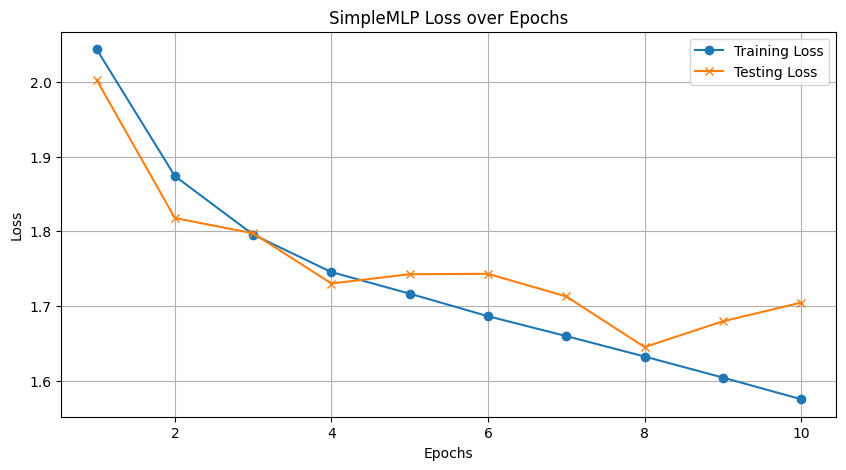

In [14]:
# Train SimpleMLP
simple_mlp = SimpleMLP().to(device)
optimizer = optim.Adam(simple_mlp.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
simple_train_losses, simple_test_losses = [], []
simple_train_accs, simple_test_accs = [], []

print("Training SimpleMLP...")
for epoch in range(num_epochs):
    train_loss, train_acc = train(simple_mlp, trainloader, optimizer, criterion)
    test_loss, test_acc = test(simple_mlp, testloader, criterion)
    simple_train_losses.append(train_loss)
    simple_test_losses.append(test_loss)
    simple_train_accs.append(train_acc)
    simple_test_accs.append(test_acc)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

plot_loss(
    num_epochs,
    simple_train_losses,
    simple_test_losses,
    title='SimpleMLP Loss over Epochs',
    save_path='results/simpleMLP_loss_acc_curve.png'
)

Training MLPWithBatchNorm...
Epoch [1/10], Train Loss: 2.0139, Train Acc: 26.08%, Test Loss: 1.9132, Test Acc: 31.80%
Epoch [1/10], Train Loss: 2.0139, Train Acc: 26.08%, Test Loss: 1.9132, Test Acc: 31.80%
Epoch [2/10], Train Loss: 1.8348, Train Acc: 33.76%, Test Loss: 1.8551, Test Acc: 34.40%
Epoch [2/10], Train Loss: 1.8348, Train Acc: 33.76%, Test Loss: 1.8551, Test Acc: 34.40%
Epoch [3/10], Train Loss: 1.7589, Train Acc: 35.90%, Test Loss: 1.7683, Test Acc: 39.60%
Epoch [3/10], Train Loss: 1.7589, Train Acc: 35.90%, Test Loss: 1.7683, Test Acc: 39.60%
Epoch [4/10], Train Loss: 1.7231, Train Acc: 37.16%, Test Loss: 1.6943, Test Acc: 40.60%
Epoch [4/10], Train Loss: 1.7231, Train Acc: 37.16%, Test Loss: 1.6943, Test Acc: 40.60%
Epoch [5/10], Train Loss: 1.6801, Train Acc: 39.18%, Test Loss: 1.6954, Test Acc: 40.80%
Epoch [5/10], Train Loss: 1.6801, Train Acc: 39.18%, Test Loss: 1.6954, Test Acc: 40.80%
Epoch [6/10], Train Loss: 1.6485, Train Acc: 39.64%, Test Loss: 1.6765, Test Acc:

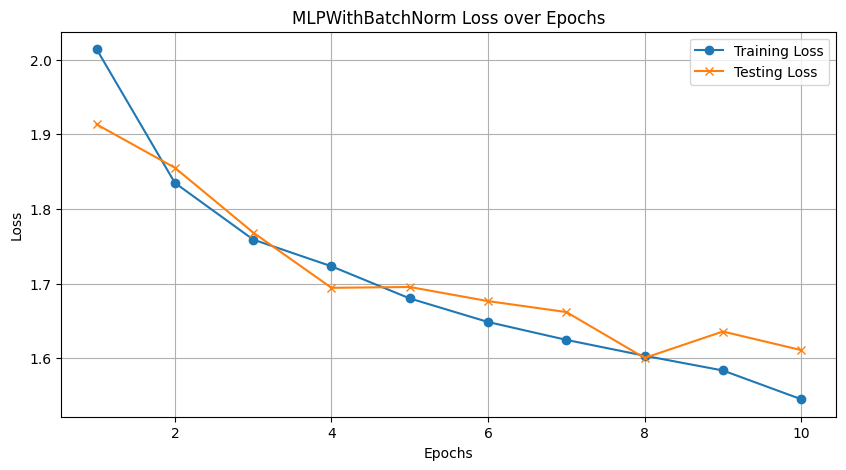

In [15]:
# Train MLPWithBatchNorm
bn_mlp = MLPWithBatchNorm().to(device)
optimizer = optim.Adam(bn_mlp.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
bn_train_losses, bn_test_losses = [], []
bn_train_accs, bn_test_accs = [], []

print("Training MLPWithBatchNorm...")
for epoch in range(num_epochs):
    train_loss, train_acc = train(bn_mlp, trainloader, optimizer, criterion)
    test_loss, test_acc = test(bn_mlp, testloader, criterion)
    bn_train_losses.append(train_loss)
    bn_test_losses.append(test_loss)
    bn_train_accs.append(train_acc)
    bn_test_accs.append(test_acc)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

plot_loss(
    num_epochs,
    bn_train_losses,
    bn_test_losses,
    title='MLPWithBatchNorm Loss over Epochs',
    save_path='results/batchnorm_loss_acc_curve.png'
)

Training MLPWithDropout...
Epoch [1/10], Train Loss: 2.1668, Train Acc: 20.26%, Test Loss: 1.9838, Test Acc: 31.20%
Epoch [1/10], Train Loss: 2.1668, Train Acc: 20.26%, Test Loss: 1.9838, Test Acc: 31.20%
Epoch [2/10], Train Loss: 2.0185, Train Acc: 26.16%, Test Loss: 1.9067, Test Acc: 33.40%
Epoch [2/10], Train Loss: 2.0185, Train Acc: 26.16%, Test Loss: 1.9067, Test Acc: 33.40%
Epoch [3/10], Train Loss: 1.9612, Train Acc: 28.08%, Test Loss: 1.8679, Test Acc: 32.40%
Epoch [3/10], Train Loss: 1.9612, Train Acc: 28.08%, Test Loss: 1.8679, Test Acc: 32.40%
Epoch [4/10], Train Loss: 1.9397, Train Acc: 29.40%, Test Loss: 1.8032, Test Acc: 34.20%
Epoch [4/10], Train Loss: 1.9397, Train Acc: 29.40%, Test Loss: 1.8032, Test Acc: 34.20%
Epoch [5/10], Train Loss: 1.8936, Train Acc: 30.96%, Test Loss: 1.8121, Test Acc: 35.20%
Epoch [5/10], Train Loss: 1.8936, Train Acc: 30.96%, Test Loss: 1.8121, Test Acc: 35.20%
Epoch [6/10], Train Loss: 1.8763, Train Acc: 31.68%, Test Loss: 1.8169, Test Acc: 3

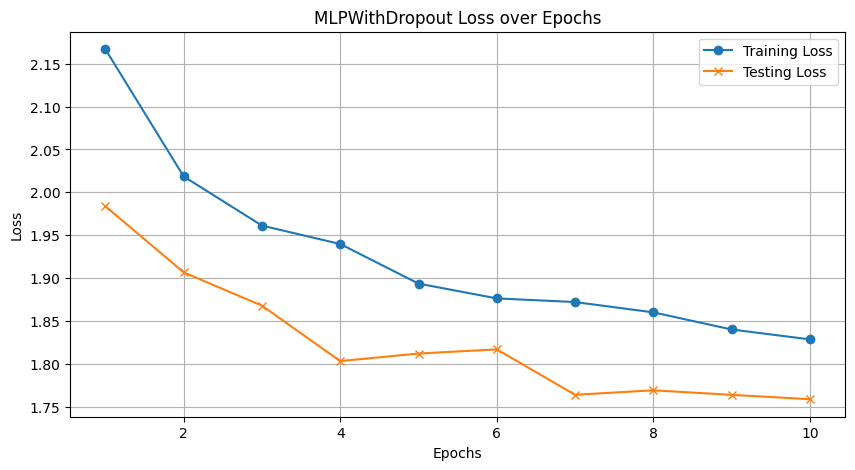

In [16]:
# Training MLPWithDropout
dropout_mlp = MLPWithDropout().to(device)
optimizer = optim.Adam(dropout_mlp.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
dropout_train_losses, dropout_test_losses = [], []
dropout_train_accs, dropout_test_accs = [], []

print("Training MLPWithDropout...")
for epoch in range(num_epochs):
    train_loss, train_acc = train(dropout_mlp, trainloader, optimizer, criterion)
    test_loss, test_acc = test(dropout_mlp, testloader, criterion)
    dropout_train_losses.append(train_loss)
    dropout_test_losses.append(test_loss)
    dropout_train_accs.append(train_acc)
    dropout_test_accs.append(test_acc)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

plot_loss(
    num_epochs,
    dropout_train_losses,
    dropout_test_losses,
    title='MLPWithDropout Loss over Epochs',
    save_path='results/dropout_loss_acc_curve.png'
)

Training MLPWithBatchNormDropout...
Epoch [1/10], Train Loss: 2.1767, Train Acc: 21.00%, Test Loss: 1.9641, Test Acc: 29.00%
Epoch [1/10], Train Loss: 2.1767, Train Acc: 21.00%, Test Loss: 1.9641, Test Acc: 29.00%
Epoch [2/10], Train Loss: 2.0184, Train Acc: 25.38%, Test Loss: 1.9017, Test Acc: 31.40%
Epoch [2/10], Train Loss: 2.0184, Train Acc: 25.38%, Test Loss: 1.9017, Test Acc: 31.40%
Epoch [3/10], Train Loss: 1.9583, Train Acc: 28.96%, Test Loss: 1.8382, Test Acc: 33.60%
Epoch [3/10], Train Loss: 1.9583, Train Acc: 28.96%, Test Loss: 1.8382, Test Acc: 33.60%
Epoch [4/10], Train Loss: 1.9101, Train Acc: 29.80%, Test Loss: 1.7948, Test Acc: 36.20%
Epoch [4/10], Train Loss: 1.9101, Train Acc: 29.80%, Test Loss: 1.7948, Test Acc: 36.20%
Epoch [5/10], Train Loss: 1.8675, Train Acc: 31.74%, Test Loss: 1.7852, Test Acc: 34.80%
Epoch [5/10], Train Loss: 1.8675, Train Acc: 31.74%, Test Loss: 1.7852, Test Acc: 34.80%
Epoch [6/10], Train Loss: 1.8399, Train Acc: 32.92%, Test Loss: 1.7521, Te

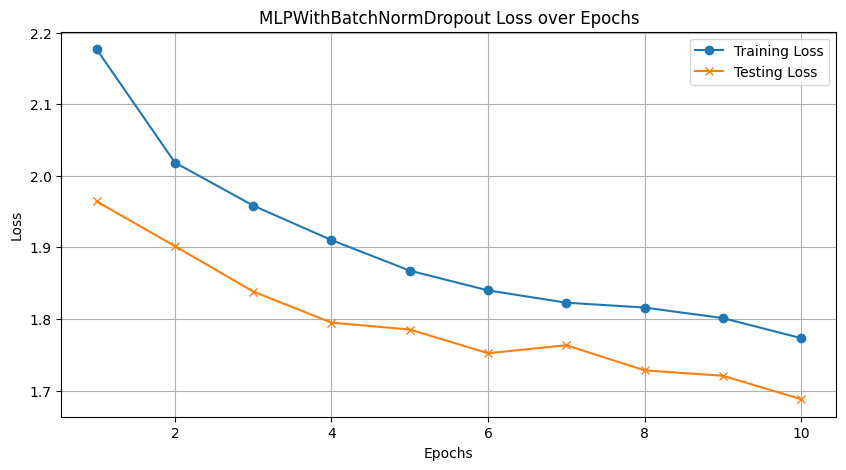

In [17]:
# Training MLPWithBatchNormDropout
bn_dropout_mlp = MLPWithBatchNormDropout().to(device)
optimizer = optim.Adam(bn_dropout_mlp.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
bn_dropout_train_losses, bn_dropout_test_losses = [], []
bn_dropout_train_accs, bn_dropout_test_accs = [], []

print("Training MLPWithBatchNormDropout...")
for epoch in range(num_epochs):
    train_loss, train_acc = train(bn_dropout_mlp, trainloader, optimizer, criterion)
    test_loss, test_acc = test(bn_dropout_mlp, testloader, criterion)
    bn_dropout_train_losses.append(train_loss)
    bn_dropout_test_losses.append(test_loss)
    bn_dropout_train_accs.append(train_acc)
    bn_dropout_test_accs.append(test_acc)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

plot_loss(
    num_epochs,
    bn_dropout_train_losses,
    bn_dropout_test_losses,
    title='MLPWithBatchNormDropout Loss over Epochs',
    save_path='results/batchnorm_dropout_loss_acc_curve.png'
)

#### Question: Analysis the results and find out whether any of the above techniques is useful for training this MLP for CIFAR-10 classification. Explain why/how they work?

### Step4: Design a MLP that has deeper layers with Redisual Blocks
#### 20 层深度 MLP ———— 20 层全连接，每层后都加 BatchNorm

In [18]:
# A deeper MLP with 20 layers (调整：从50层减到20层提升稳定性)
class DeepMLP(nn.Module):
    def __init__(self, input_size=32*32*3, num_classes=10, hidden_size=512, num_layers=20):
        super(DeepMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        
        # Stack multiple hidden layers
        self.hidden_layers = nn.ModuleList([ #? nn.ModuleList 用于动态堆叠多层
            nn.Linear(hidden_size, hidden_size) for _ in range(num_layers)
        ])
        self.bn_layers = nn.ModuleList([
            nn.BatchNorm1d(hidden_size) for _ in range(num_layers)
        ])
        
        self.fc_out = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        
        x = x.view(-1, 32*32*3)
        x = F.relu(self.bn1(self.fc1(x)))

        # Pass through deep hidden layers
        for i in range(len(self.hidden_layers)):
            x = F.relu(self.bn_layers[i](self.hidden_layers[i](x)))
        
        # Output layer for classification
        x = self.fc_out(x)
        
        return x

####  残差块与深层残差 MLP
残差块，也就是下面儿的ResidualMLPBlock 
———— 输入经过两层全连接+BN+Dropout后与原输入相加（skip connection），再激活

深层残差 MLP，即下面的DeepResidualMLP
———— 堆叠多个残差块，极大缓解深层网络的梯度消失问题

In [19]:
# Design a residual block
# input -> Linear -> batchnorm -> activation -> dropout -> Linear -> batchnorm -> skip connection -> activation -> output
class ResidualMLPBlock(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_prob=0.3):  
        super(ResidualMLPBlock, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
    
    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.fc1(x)))
        out = self.dropout(out)
        out = self.bn2(self.fc2(out))
        out += residual
        out = F.relu(out)
        return out

# Design MLP with residual blocks
# Use nn.ModuleList 
# input -> Linear -> batchnorm -> activation -> residual layers -> classifacation layer
class DeepResidualMLP(nn.Module):
    def __init__(self, input_size=32*32*3, num_classes=10, hidden_size=512, num_layers=20, dropout_prob=0.3):  
        super(DeepResidualMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        
        self.residual_blocks = nn.ModuleList([
            ResidualMLPBlock(hidden_size, hidden_size, dropout_prob) 
            for _ in range(num_layers)
        ])
        
        self.fc_out = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = F.relu(self.bn1(self.fc1(x)))
        
        for block in self.residual_blocks:
            x = block(x)
        
        x = self.fc_out(x)
        return x

Training DeepMLP...
Epoch [1/10], Train Loss: 2.2976, Train Acc: 14.16%, Test Loss: 2.4089, Test Acc: 8.00%
Epoch [1/10], Train Loss: 2.2976, Train Acc: 14.16%, Test Loss: 2.4089, Test Acc: 8.00%
Epoch [2/10], Train Loss: 2.1439, Train Acc: 19.92%, Test Loss: 2.5465, Test Acc: 21.00%
Epoch [2/10], Train Loss: 2.1439, Train Acc: 19.92%, Test Loss: 2.5465, Test Acc: 21.00%
Epoch [3/10], Train Loss: 2.0534, Train Acc: 23.56%, Test Loss: 2.4156, Test Acc: 27.80%
Epoch [3/10], Train Loss: 2.0534, Train Acc: 23.56%, Test Loss: 2.4156, Test Acc: 27.80%
Epoch [4/10], Train Loss: 1.9943, Train Acc: 25.34%, Test Loss: 1.9667, Test Acc: 29.60%
Epoch [4/10], Train Loss: 1.9943, Train Acc: 25.34%, Test Loss: 1.9667, Test Acc: 29.60%
Epoch [5/10], Train Loss: 1.9460, Train Acc: 27.12%, Test Loss: 1.9118, Test Acc: 31.20%
Epoch [5/10], Train Loss: 1.9460, Train Acc: 27.12%, Test Loss: 1.9118, Test Acc: 31.20%
Epoch [6/10], Train Loss: 1.9041, Train Acc: 28.58%, Test Loss: 1.8560, Test Acc: 31.00%
Epo

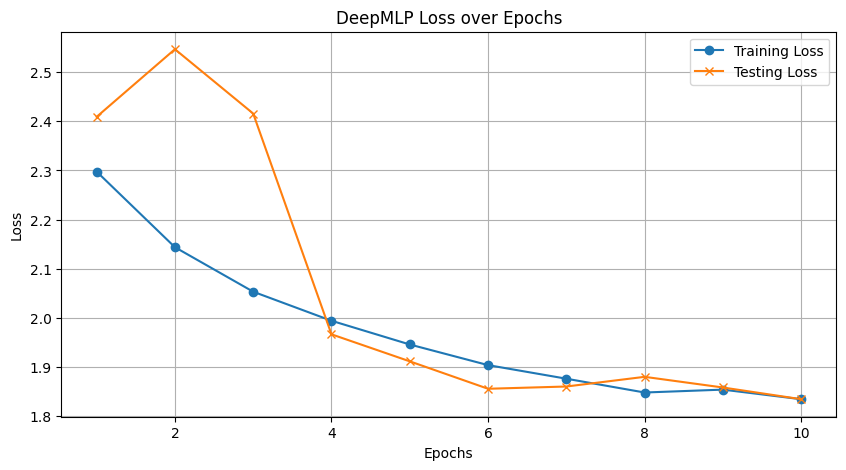

In [20]:
# Training DeepMLP
deep_mlp = DeepMLP().to(device)
optimizer = optim.Adam(deep_mlp.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()
deep_train_losses, deep_test_losses = [], []
deep_train_accs, deep_test_accs = [], []

print("Training DeepMLP...")
for epoch in range(num_epochs):
    train_loss, train_acc = train(deep_mlp, trainloader, optimizer, criterion)
    test_loss, test_acc = test(deep_mlp, testloader, criterion)
    deep_train_losses.append(train_loss)
    deep_test_losses.append(test_loss)
    deep_train_accs.append(train_acc)
    deep_test_accs.append(test_acc)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

# Save the losses during training and testing and plot them using plot_loss()
plot_loss(
    num_epochs,
    deep_train_losses,
    deep_test_losses,
    title='DeepMLP Loss over Epochs',
    save_path='results/deepMLP_loss_acc_curve.png'
)

Training DeepResidualMLP...
Epoch [1/10], Train Loss: 3.0993, Train Acc: 15.30%, Test Loss: 2.5545, Test Acc: 18.20%
Epoch [1/10], Train Loss: 3.0993, Train Acc: 15.30%, Test Loss: 2.5545, Test Acc: 18.20%
Epoch [2/10], Train Loss: 2.5291, Train Acc: 19.20%, Test Loss: 4.7666, Test Acc: 22.20%
Epoch [2/10], Train Loss: 2.5291, Train Acc: 19.20%, Test Loss: 4.7666, Test Acc: 22.20%
Epoch [3/10], Train Loss: 2.4101, Train Acc: 21.34%, Test Loss: 2.4662, Test Acc: 27.20%
Epoch [3/10], Train Loss: 2.4101, Train Acc: 21.34%, Test Loss: 2.4662, Test Acc: 27.20%
Epoch [4/10], Train Loss: 2.2134, Train Acc: 24.62%, Test Loss: 2.6885, Test Acc: 29.80%
Epoch [4/10], Train Loss: 2.2134, Train Acc: 24.62%, Test Loss: 2.6885, Test Acc: 29.80%
Epoch [5/10], Train Loss: 2.1382, Train Acc: 27.70%, Test Loss: 2.2194, Test Acc: 28.40%
Epoch [5/10], Train Loss: 2.1382, Train Acc: 27.70%, Test Loss: 2.2194, Test Acc: 28.40%
Epoch [6/10], Train Loss: 2.0240, Train Acc: 28.66%, Test Loss: 1.9994, Test Acc: 

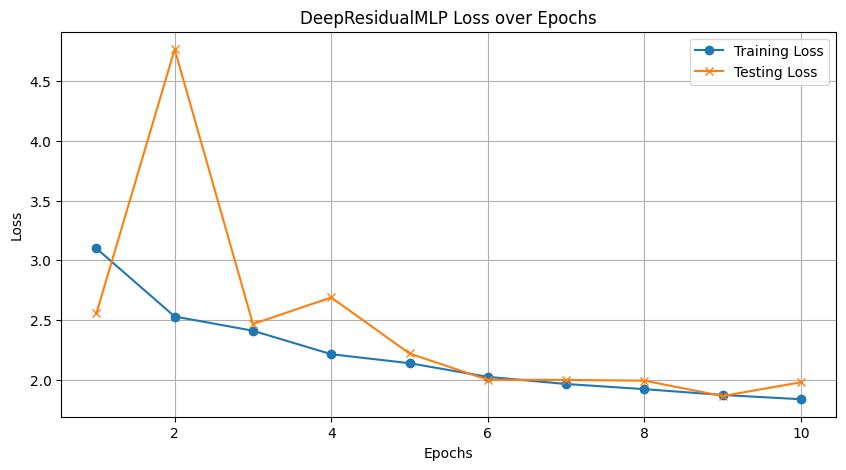

In [21]:
# Training DeepResidualMLP
residual_mlp = DeepResidualMLP().to(device)
optimizer = optim.Adam(residual_mlp.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss()
residual_train_losses, residual_test_losses = [], []
residual_train_accs, residual_test_accs = [], []

print("Training DeepResidualMLP...")
for epoch in range(num_epochs):
    train_loss, train_acc = train(residual_mlp, trainloader, optimizer, criterion)
    test_loss, test_acc = test(residual_mlp, testloader, criterion)
    residual_train_losses.append(train_loss)
    residual_test_losses.append(test_loss)
    residual_train_accs.append(train_acc)
    residual_test_accs.append(test_acc)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

# Save the losses during training and testing and plot them using plot_loss()
plot_loss(
    num_epochs,
    residual_train_losses,
    residual_test_losses,
    title='DeepResidualMLP Loss over Epochs',
    save_path='results/deepResidualMLP_loss_acc_curve.png'
)

#### Bonus: Try to see the gradient flow when training the above networks
#### 梯度流可视化

取一个 batch，分别对每个模型 **前向+反向** 传播，统计每一层参数的平均/最大梯度，画成柱状图。
这样可以直观看到不同结构下梯度消失/爆炸的情况

Visualizing gradient flow for SimpleMLP...


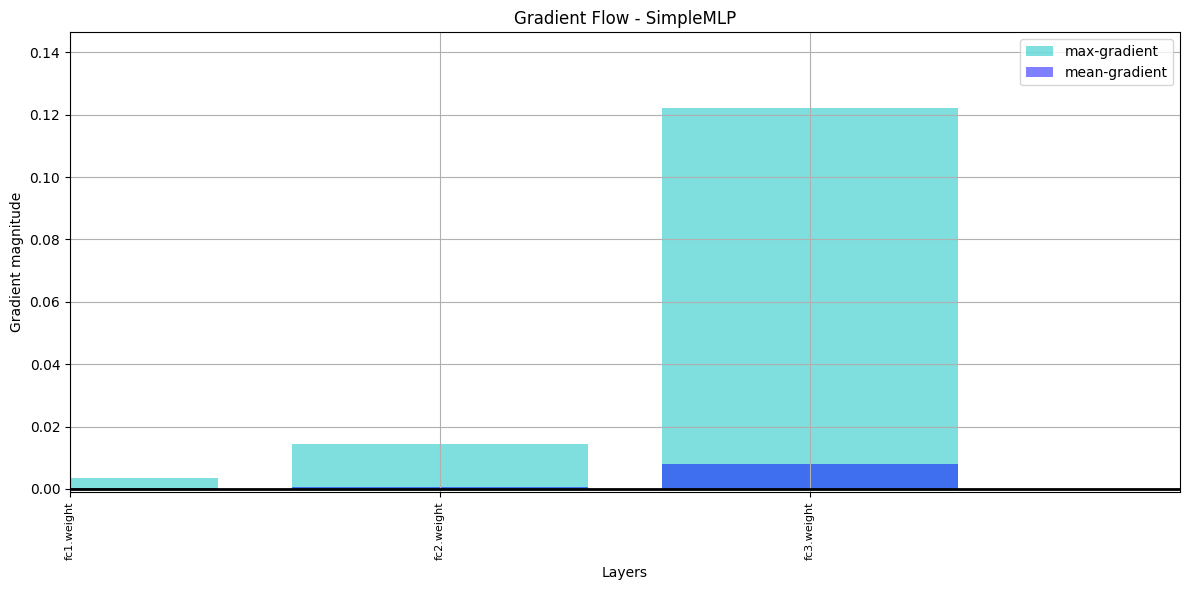

Visualizing gradient flow for MLPWithBatchNorm...


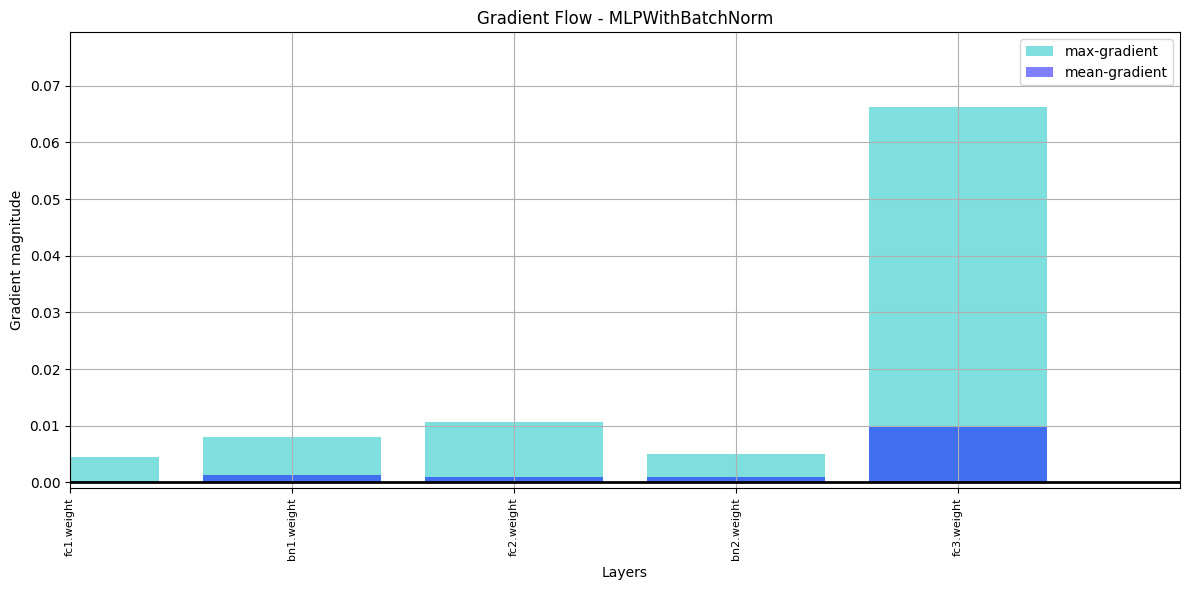

Visualizing gradient flow for MLPWithDropout...


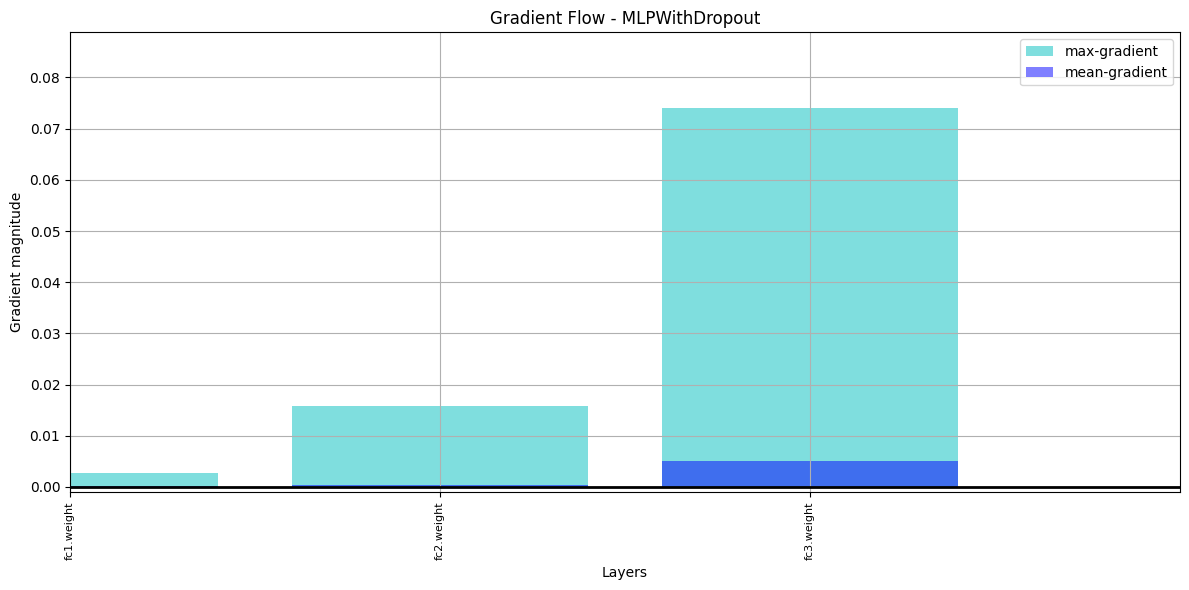

Visualizing gradient flow for MLPWithBatchNormDropout...


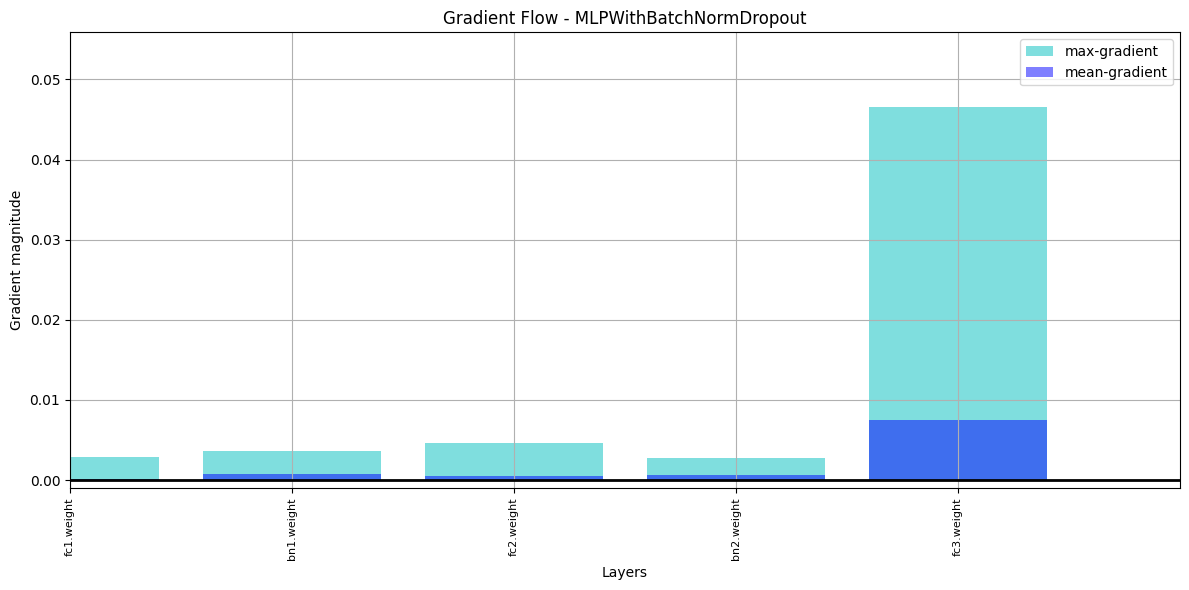

Visualizing gradient flow for DeepResidualMLP...


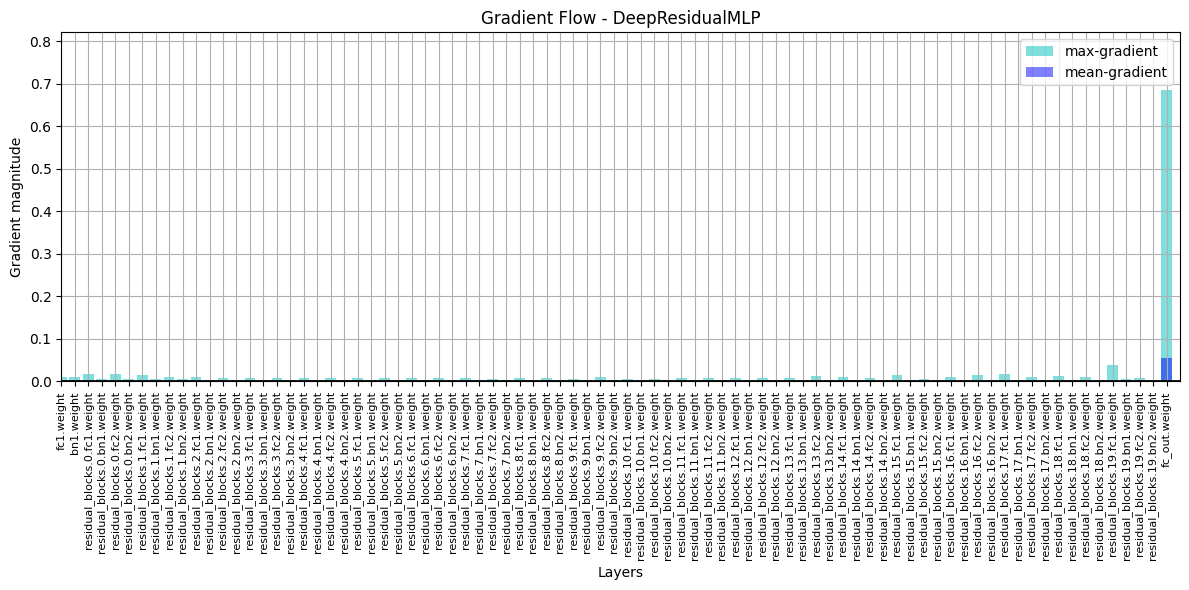

In [22]:
from typing import Optional
def plot_gradient_flow(model, model_name: str, save_path: Optional[str] = None):
    """Visualize gradient flow through the network during backpropagation."""
    ave_grads = []
    max_grads = []
    layers = []
    
    for name, param in model.named_parameters():
        if param.requires_grad and ("bias" not in name) and param.grad is not None:
            layers.append(name)
            ave_grads.append(param.grad.abs().mean().cpu().item())
            max_grads.append(param.grad.abs().max().cpu().item())
    
    plt.figure(figsize=(12, 6))
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.5, lw=1, color="c", label="max-gradient")
    plt.bar(np.arange(len(ave_grads)), ave_grads, alpha=0.5, lw=1, color="b", label="mean-gradient")
    plt.hlines(0, 0, len(ave_grads) + 1, lw=2, color="k")
    plt.xticks(range(len(ave_grads)), layers, rotation="vertical", fontsize=8)
    plt.xlim(left=0, right=len(ave_grads))
    if max_grads:
        plt.ylim(bottom=-0.001, top=max(max_grads) * 1.2)
    plt.xlabel("Layers")
    plt.ylabel("Gradient magnitude")
    plt.title(f"Gradient Flow - {model_name}")
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Use a single mini-batch to inspect gradient flow
sample_images, sample_labels = next(iter(trainloader))
sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)

models_for_gradients = [
    (simple_mlp, "SimpleMLP", "results/gradient_flow_simpleMLP.png"),
    (bn_mlp, "MLPWithBatchNorm", "results/gradient_flow_batchnorm.png"),
    (dropout_mlp, "MLPWithDropout", "results/gradient_flow_dropout.png"),
    (bn_dropout_mlp, "MLPWithBatchNormDropout", "results/gradient_flow_batchnorm_dropout.png"),
    (residual_mlp, "DeepResidualMLP", "results/gradient_flow_residual.png"),
]

for model, name, path in models_for_gradients:
    print(f"Visualizing gradient flow for {name}...")
    model.zero_grad()
    outputs = model(sample_images)
    grad_loss = nn.CrossEntropyLoss()(outputs, sample_labels)
    grad_loss.backward()
    plot_gradient_flow(model, name, save_path=path)

### 对比所有模型的测试准确率

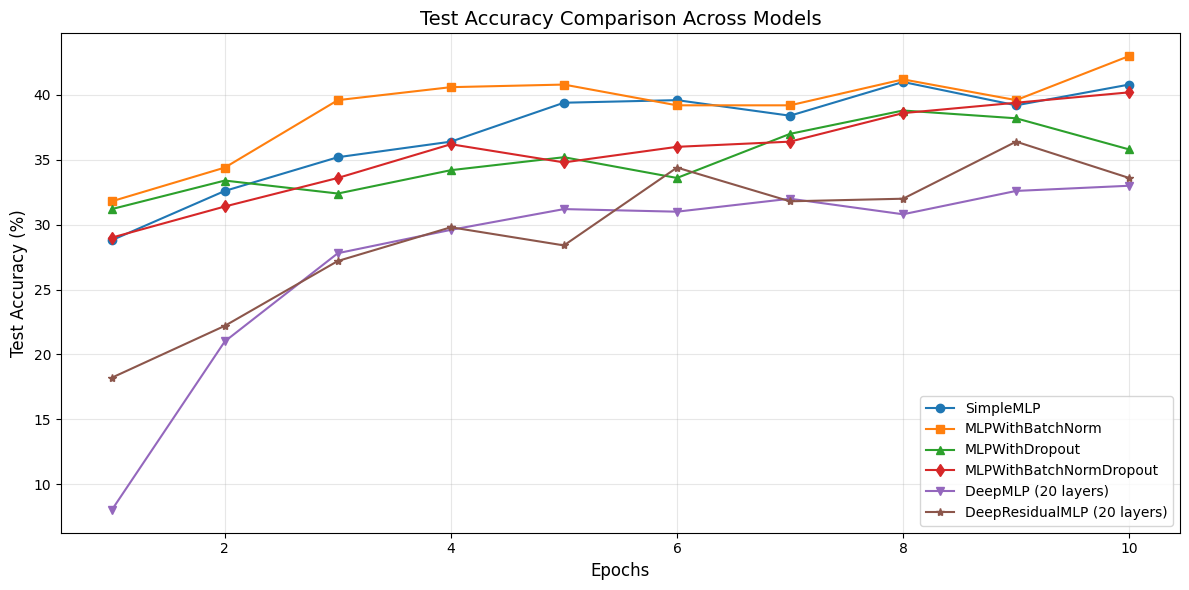

Comparison accuracy plot saved to results/comparison_accuracy.png


In [23]:
# 生成 comparison_accuracy.png：对比所有模型的测试准确率
plt.figure(figsize=(12, 6))

# 绘制所有模型的测试准确率
plt.plot(range(1, num_epochs + 1), simple_test_accs, label='SimpleMLP', marker='o')
plt.plot(range(1, num_epochs + 1), bn_test_accs, label='MLPWithBatchNorm', marker='s')
plt.plot(range(1, num_epochs + 1), dropout_test_accs, label='MLPWithDropout', marker='^')
plt.plot(range(1, num_epochs + 1), bn_dropout_test_accs, label='MLPWithBatchNormDropout', marker='d')
plt.plot(range(1, num_epochs + 1), deep_test_accs, label='DeepMLP (20 layers)', marker='v')
plt.plot(range(1, num_epochs + 1), residual_test_accs, label='DeepResidualMLP (20 layers)', marker='*')

plt.title('Test Accuracy Comparison Across Models', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Test Accuracy (%)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 保存到 results 目录
os.makedirs('results', exist_ok=True)
plt.savefig('results/comparison_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("Comparison accuracy plot saved to results/comparison_accuracy.png")